In [1]:
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

from keras.applications import (vgg16,  vgg19, xception, 
                                inception_v3,  inception_resnet_v2, 
                                mobilenet,densenet, nasnet, mobilenet_v2)

nb_closest_images = 5 # number of most similar images to retrieve

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
#https://www.kaggle.com/jonathanoheix/product-recommendation-based-on-visual-similarity
import os
"""os.chdir'/home/jupyter/train/')
files = ['D:/Documents/MangAI/src/Dataset/pictures/' + x for x in os.listdir() if x.endswith('jpg')]
files[:10]"""

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

"os.chdir'/home/jupyter/train/')\nfiles = ['D:/Documents/MangAI/src/Dataset/pictures/' + x for x in os.listdir() if x.endswith('jpg')]\nfiles[:10]"

In [2]:
files = [x for x in os.listdir("product_img/") if x.endswith('jpg')]
files = np.random.choice(files, 2000)

In [3]:
#! sudo rm -r img && sudo mkdir img && sudo gsutil -m cp -r gs://poc_ua/images/p* img/.

In [11]:
manga = pd.read_csv('/home/jupyter/MangaInfo (1).csv')
manga.head()

,title,genre,poster,staff,score,synopsis,popularity
0,Z,"Action , Comedy , Mystery , Drama , Shoujo , H...",https://cdn.myanimelist.net/images/manga/2/457...,Aoike Yasuko,7.03,"The adventures of Agent Z, the newest recruit ...",24669
1,y,"Hentai , School , Doujinshi",https://cdn.myanimelist.net/images/manga/2/153...,Kishi Kaisei,6.24,1. y[16:21-20:47] Imakara Atashi Okasaremasu.,25046
2,Zion_no_Koeda,"Drama , Historical , Yaoi , Magazine Be x Boy",https://cdn.myanimelist.net/images/manga/3/251...,Inariya Fusanosuke,7.04,A former Nazi official is kept captive by the ...,4242
3,Yuuwaku_no_Bansan,"Romance , Josei",https://cdn.myanimelist.net/images/manga/2/116...,Katsumoto Kasane,6.70,From StarryHeaven:,4916
4,Yume_no_Akichi,"Dementia , Drama , Fantasy , Supernatural , Ps...",https://cdn.myanimelist.net/images/manga/3/137...,Oda Hideji,7.02,Renei thinks she's going crazy. After many yea...,14175


In [12]:
manga["title"] = manga["title"].replace({"%" : ""}, regex=True)
manga= manga[(manga["title"] != "") & (manga["title"].notnull()) & (manga["poster"].notnull())]

In [ ]:
! sudo mkdir img && sudo gsutil -m cp -r gs://poc_ua/images/* img/.

In [ ]:
import requests
from tqdm import tqdm 

for url, title in zip(manga["poster"], manga["title"]) : 
    with open('/home/jupyter/Untitled Folder/{}.jpg'.format(title), 'wb') as f:
            f.write(requests.get(url).content)


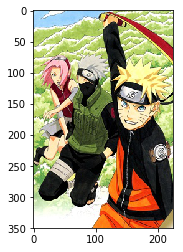

image loaded successfully!


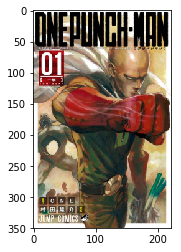

image loaded successfully!


In [4]:
from urllib.request import urlopen
from PIL import Image

naruto_poster = manga.query("title == 'Naruto'")["poster"].iloc[0]
one_punch_poster = manga.query("title == 'One_Punch-Man'")["poster"].iloc[0]
#berserk_poster = manga.query("title == 'Berserk'")["poster"].iloc[0]

for poster in [naruto_poster, one_punch_poster] :
    img = Image.open(urlopen(poster))
    plt.imshow(img)
    plt.show()
    print("image loaded successfully!")

In [3]:


class ImageRecommender : 
    
    def __init__(self, model, list_of_image, filespath) : 
        self.model = model
        self.filespath = filespath
        self.list_of_image = list_of_image
        #since ouput.shape return object dimension just eval it to get integer ...
        self.image_width = eval(str(self.model.layers[0].output.shape[1]))
        self.image_height = eval(str(self.model.layers[0].output.shape[2]))
        # remove the last layers in order to get features instead of predictions
        self.image_features_extractor = Model(inputs=self.model.input, 
                                              outputs=self.model.layers[-2].output)
        self.processed_image = self.Pics2Matrix()
        self.sim_table = self.GetSimilarity(self.processed_image)
        
    def ddl_images(self, image_url) :
        try : 
            return load_img(self.filespath + image_url, 
                            target_size=(self.image_width, self.image_height))
        except OSError : 
            # image unreadable // remove from list
            self.list_of_image = [x for x in self.list_of_image if x != image_url]
            #self.list_of_image.remove(image_url)
            pass
        
    def Pics2Matrix(self) :
        """
        # convert the PIL image to a numpy array
        # in PIL - image is in (width, height, channel)
        # in Numpy - image is in (height, width, channel)
        # convert the image / images into batch format
        # expand_dims will add an extra dimension to the data at a particular axis
        # we want the input matrix to the network to be of the form (batchsize, height, width, channels)
        # thus we add the extra dimension to the axis 0.
        """
        #from keras.preprocessing.image import load_img,img_to_array
        list_of_expanded_array = list()
        for i in tqdm(range(len(self.list_of_image) - 1)) :
            try :
                tmp = img_to_array(self.ddl_images(self.list_of_image[i]))
                expand = np.expand_dims(tmp, axis = 0)
                list_of_expanded_array.append(expand)
            except ValueError : 
                self.list_of_image = [x for x in self.list_of_image if x != self.list_of_image[i]]
                #self.list_of_image.remove(self.list_of_image[i])
        images = np.vstack(list_of_expanded_array)
        """
        list_of_expanded_array = [try np.expand_dims(img_to_array(self.ddl_images(self.list_of_image[i])), axis = 0) except ValueError pass \
                                  for i in tqdm(range(len(self.list_of_image)))]
        images = np.vstack(list_of_expanded_array)
        #from keras.applications.imagenet_utils import preprocess_input()
        # prepare the image for the  model"
        """
        return preprocess_input(images)
    
    def GetSimilarity(self, processed_imgs) :
        print('============ algorithm predict featurs =========')
        imgs_features = self.image_features_extractor.predict(processed_imgs)
        print("Our image has %i features:" %imgs_features.size)
        cosSimilarities = cosine_similarity(imgs_features)
        cos_similarities_df = pd.DataFrame(cosSimilarities, 
                                           columns=self.list_of_image[:len(self.list_of_image) -1],
                                           index=self.list_of_image[:len(self.list_of_image) -1])
        return cos_similarities_df
    
    def most_similar_to(self, given_img, nb_closest_images = 5):

        print("-----------------------------------------------------------------------")
        print("original manga:")

        original = self.ddl_images(given_img)
        plt.imshow(original)
        plt.show()

        print("-----------------------------------------------------------------------")
        print("most similar manga:")

        closest_imgs = self.sim_table[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
        closest_imgs_scores = self.sim_table[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

        for i in range(0,len(closest_imgs)):
            original = self.ddl_images(closest_imgs[i])
            plt.imshow(original)
            plt.show()
            print("similarity score : ",closest_imgs_scores[i])

In [4]:
vgg_model = vgg16.VGG16(weights='imagenet')

mobv2= mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, 
                                       include_top=True, 
                                       weights='imagenet')

nasnetmobile = nasnet.NASNetMobile(weights="imagenet")

mobilenet_ = mobilenet.MobileNet(weights="imagenet")

incepv2 = inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', 
                                                input_tensor=None, input_shape=None, pooling=None, classes=1000)

incepv3 = inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, 
                                   input_shape=None, pooling=None, classes=1000)

Xception_ = xception.Xception(include_top=True, weights='imagenet', input_tensor=None, 
                              input_shape=None, pooling=None, classes=1000)


W1001 18:15:51.335967 140681515931392 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1001 18:15:51.558029 140681515931392 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1001 18:15:51.726886 140681515931392 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1001 18:15:51.916713 140681515931392 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1001 18:15:57.211679 140681515931392 deprecation_wrapp

  0%|          | 1/1999 [00:00<03:31,  9.44it/s]

 /t pretrained model <keras.engine.training.Model object at 0x7ff2be8f6978> are running


100%|██████████| 1999/1999 [00:44<00:00, 45.09it/s]


============ algorithm predict featurs =========
Our image has 2558720 features:
Most similar to Naruto
Most similar to OnePunch-Man
-----------------------------------------------------------------------
original manga:


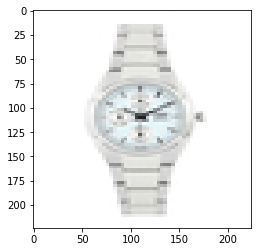

-----------------------------------------------------------------------
most similar manga:


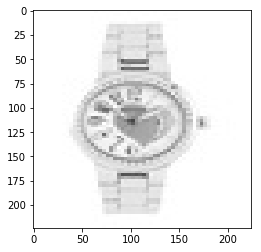

similarity score :  0.9209492


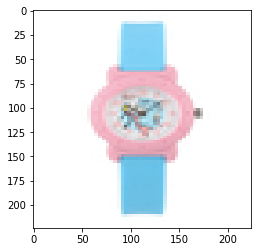

similarity score :  0.89300734


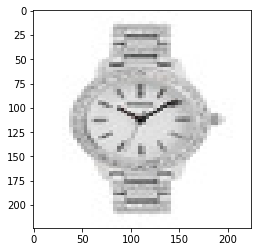

similarity score :  0.8852067


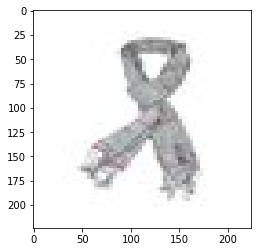

similarity score :  0.88169354


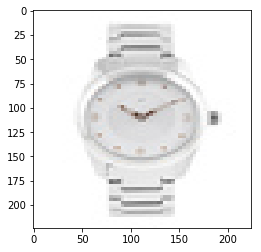

similarity score :  0.88025963
-----------------------------------------------------------------------
original manga:


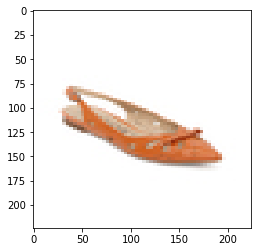

-----------------------------------------------------------------------
most similar manga:


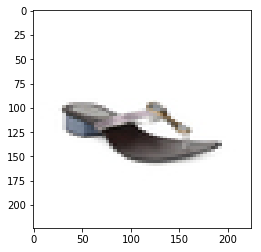

similarity score :  0.85470796


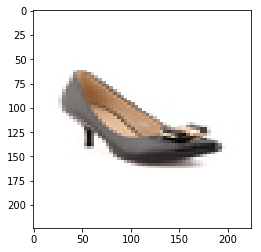

similarity score :  0.8521917


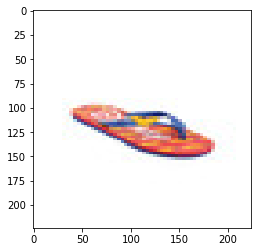

similarity score :  0.84950703


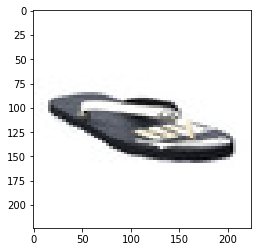

similarity score :  0.8494439


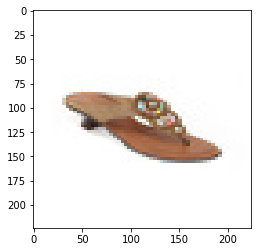

similarity score :  0.8479439
Next model ...


 /t pretrained model <keras.engine.training.Model object at 0x7ff1f6e689b0> are running


100%|██████████| 1999/1999 [00:02<00:00, 932.52it/s]


============ algorithm predict featurs =========
Our image has 2110944 features:
Most similar to Naruto
Most similar to OnePunch-Man
-----------------------------------------------------------------------
original manga:


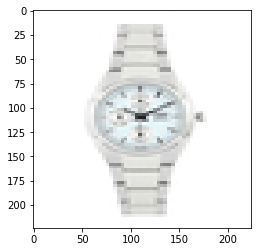

-----------------------------------------------------------------------
most similar manga:


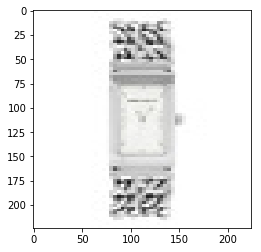

similarity score :  0.9917517


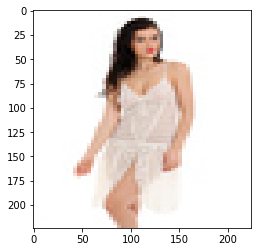

similarity score :  0.98817563


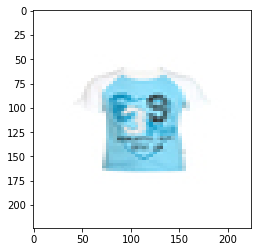

similarity score :  0.98614496


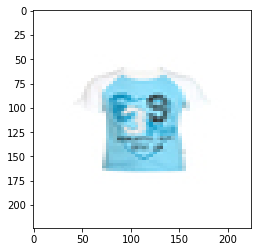

similarity score :  0.98614496


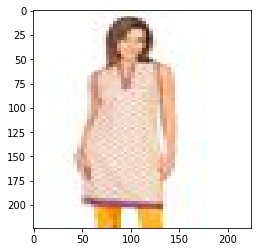

similarity score :  0.9848719
-----------------------------------------------------------------------
original manga:


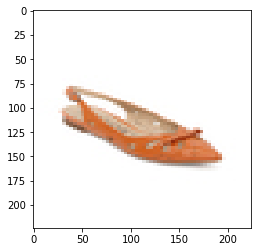

-----------------------------------------------------------------------
most similar manga:


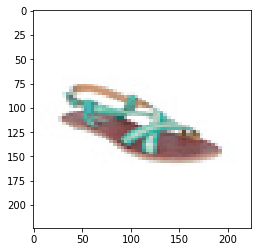

similarity score :  0.9971626


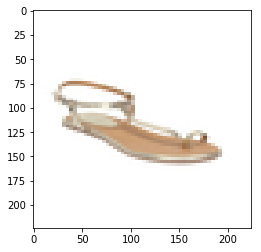

similarity score :  0.99490106


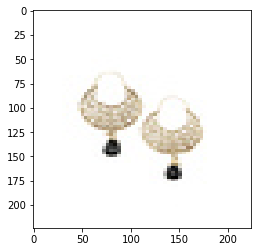

similarity score :  0.9948731


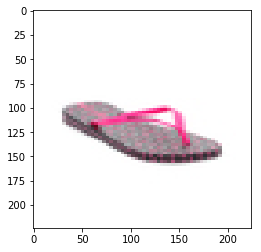

similarity score :  0.994591


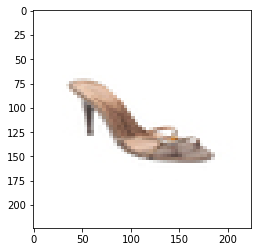

  0%|          | 0/1999 [00:00<?, ?it/s]

similarity score :  0.99364984
Next model ...


 /t pretrained model <keras.engine.training.Model object at 0x7ff1f387acf8> are running


100%|██████████| 1999/1999 [00:02<00:00, 997.09it/s]


============ algorithm predict featurs =========
Our image has 1999000 features:
Most similar to Naruto
Most similar to OnePunch-Man
-----------------------------------------------------------------------
original manga:


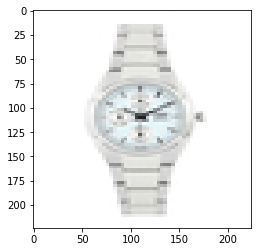

-----------------------------------------------------------------------
most similar manga:


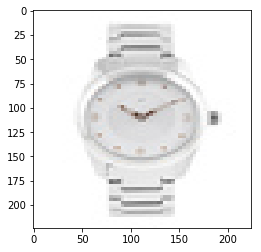

similarity score :  0.9195257


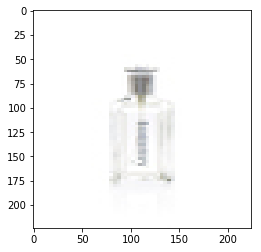

similarity score :  0.9020527


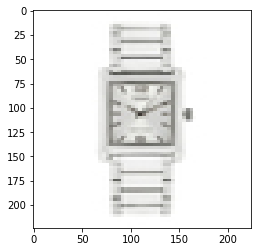

similarity score :  0.8977821


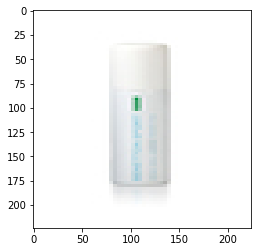

similarity score :  0.89728796


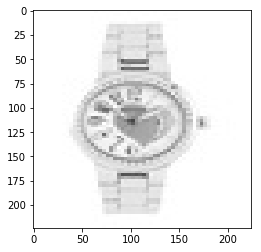

similarity score :  0.89448565
-----------------------------------------------------------------------
original manga:


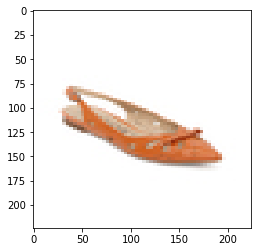

-----------------------------------------------------------------------
most similar manga:


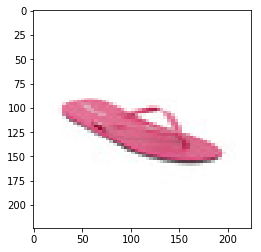

similarity score :  0.8632636


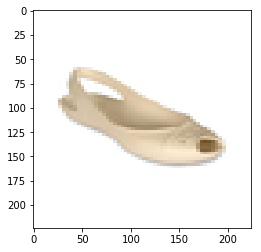

similarity score :  0.85487425


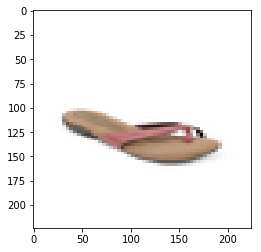

similarity score :  0.84211475


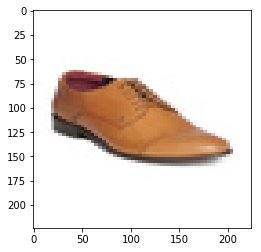

similarity score :  0.83945215


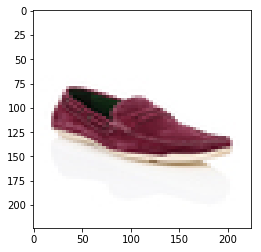

similarity score :  0.8341781
Next model ...


 /t pretrained model <keras.engine.training.Model object at 0x7ff1e7c30be0> are running


100%|██████████| 1999/1999 [00:02<00:00, 751.95it/s]


============ algorithm predict featurs =========
Our image has 3070464 features:
Most similar to Naruto
Most similar to OnePunch-Man
-----------------------------------------------------------------------
original manga:


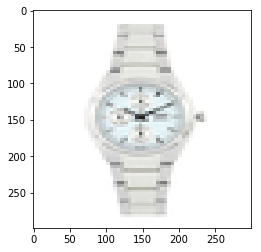

-----------------------------------------------------------------------
most similar manga:


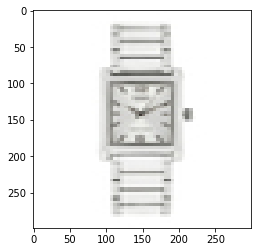

similarity score :  0.9998672


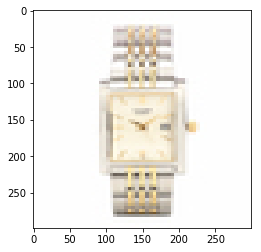

similarity score :  0.9998516


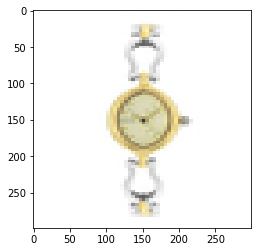

similarity score :  0.99984837


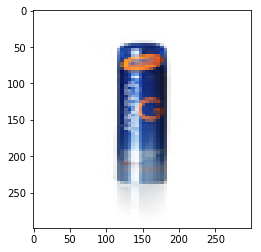

similarity score :  0.99981356


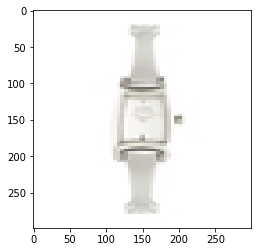

similarity score :  0.9997839
-----------------------------------------------------------------------
original manga:


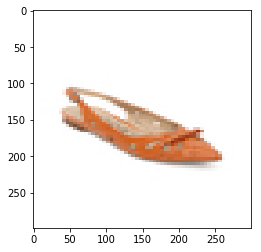

-----------------------------------------------------------------------
most similar manga:


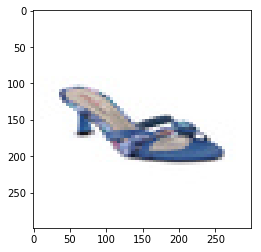

similarity score :  0.99996835


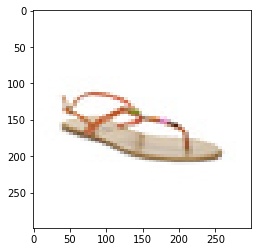

similarity score :  0.9999584


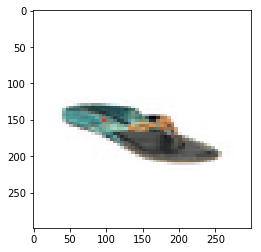

similarity score :  0.99994993


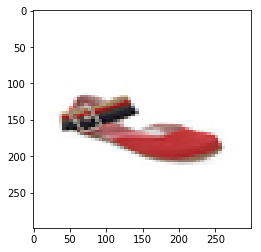

similarity score :  0.9999432


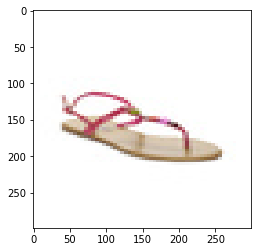

  0%|          | 0/1999 [00:00<?, ?it/s]

similarity score :  0.99992985
Next model ...


 /t pretrained model <keras.engine.training.Model object at 0x7ff0605c89e8> are running


100%|██████████| 1999/1999 [00:02<00:00, 752.82it/s]


============ algorithm predict featurs =========
Our image has 4093952 features:
Most similar to Naruto
Most similar to OnePunch-Man
-----------------------------------------------------------------------
original manga:


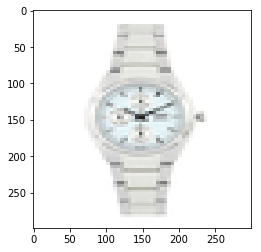

-----------------------------------------------------------------------
most similar manga:


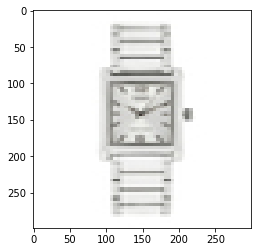

similarity score :  0.9882352


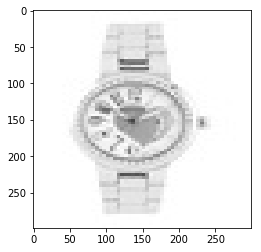

similarity score :  0.9860326


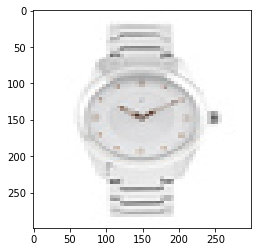

similarity score :  0.9848244


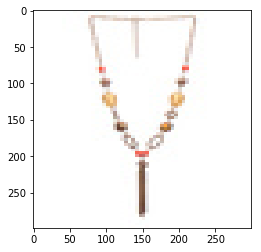

similarity score :  0.9753238


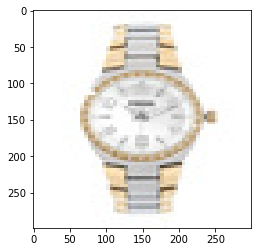

similarity score :  0.9749598
-----------------------------------------------------------------------
original manga:


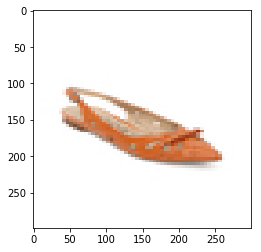

-----------------------------------------------------------------------
most similar manga:


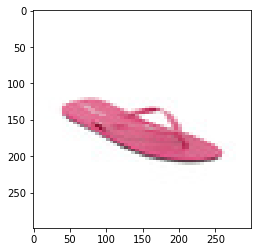

similarity score :  0.99438703


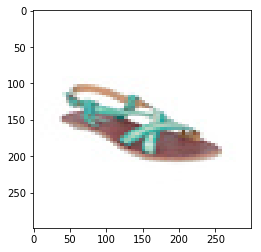

similarity score :  0.9935146


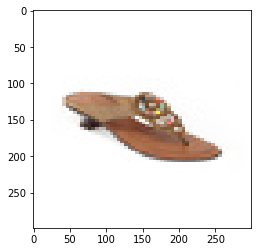

similarity score :  0.9923953


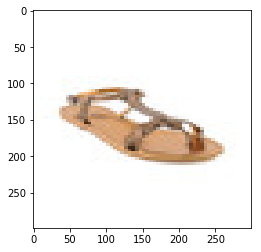

similarity score :  0.99206007


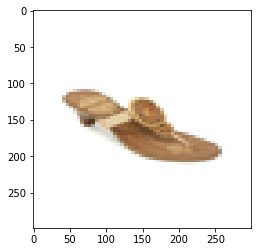

  0%|          | 0/1999 [00:00<?, ?it/s]

similarity score :  0.9912178
Next model ...


 /t pretrained model <keras.engine.training.Model object at 0x7fefa03e1748> are running


100%|██████████| 1999/1999 [00:02<00:00, 765.69it/s]


============ algorithm predict featurs =========


In [ ]:
%matplotlib inline 
from tqdm import tqdm

list_of_pretrained = [mobv2, 
                      nasnetmobile,
                      mobilenet_, 
                      incepv2,
                      incepv3,
                      Xception_, 
                      vgg_model]

for pretrained_model in list_of_pretrained : 
    print('=========================================')
    print(' /t pretrained model %s are running' %pretrained_model)
    print('=========================================')
    pretrained_recommender = ImageRecommender(pretrained_model, files, filespath = 'product_img/')
    #naruto_index, onepunch_index = files.index('Naruto.jpg'), files.index('One_Punch-Man.jpg')
    print('Most similar to Naruto')
    #pretrained_recommender.most_similar_to(files[naruto_index])
    print('Most similar to OnePunch-Man')
    #pretrained_recommender.most_similar_to(files[onepunch_index])
    print('=========================================')
    pretrained_recommender.most_similar_to(files[777])
    print('=========================================')
    pretrained_recommender.most_similar_to(files[23])
    print('Next model ...')
    print('\n')

# Scratch model 

https://www.kaggle.com/xhlulu/rsna-intracranial-simple-densenet-in-keras

In [ ]:
BATCH_SIZE = 64

def create_datagen():
    return ImageDataGenerator(validation_split=0.15)

def create_test_gen():
    return ImageDataGenerator().flow_from_dataframe(
        test_df,
        directory='/kaggle/tmp/',
        x_col='filename',
        class_mode=None,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        pivot_df, 
        directory='/kaggle/tmp/',
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='other',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()

In [ ]:
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(Dense(6, activation='sigmoid', bias_initializer=Constant(value=-5.5)))
    
    model.compile(
        loss=focal_loss,
        optimizer=Adam(lr=0.001),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

total_steps = sample_files.shape[0] / BATCH_SIZE

history = model.fit_generator(
    train_gen,
    steps_per_epoch=2000,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    callbacks=[checkpoint],
    epochs=5
)

In [ ]:
model.load_weights('model.h5')
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)